In [58]:
# %pip install matplotlib numpy opencv-python Pillow moviepy    

In [59]:
# %pip freeze

In [1]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
def list_images(images, cols = 2, rows = 5, cmap=None):
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

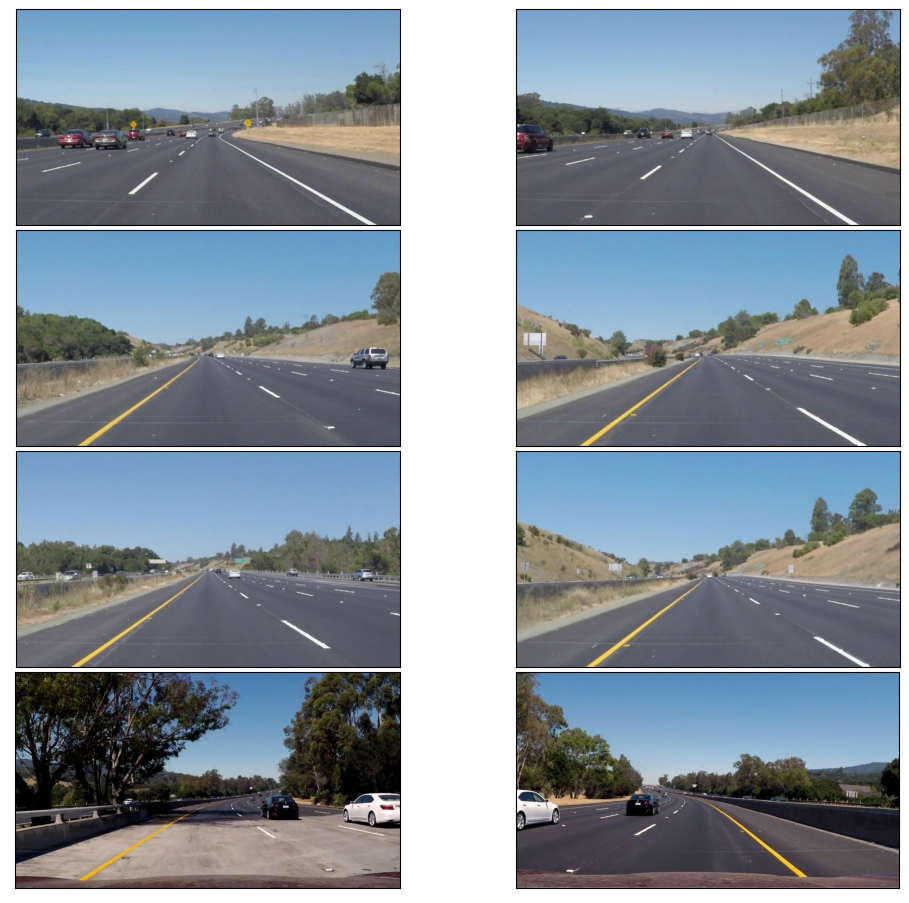

In [3]:
# test images
test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
list_images(test_images)

In [63]:
test_images[0].shape

(540, 960, 3)

In [64]:
# Based on RGB color section (white and yellow lines)
def RGB_color_selection(image):
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

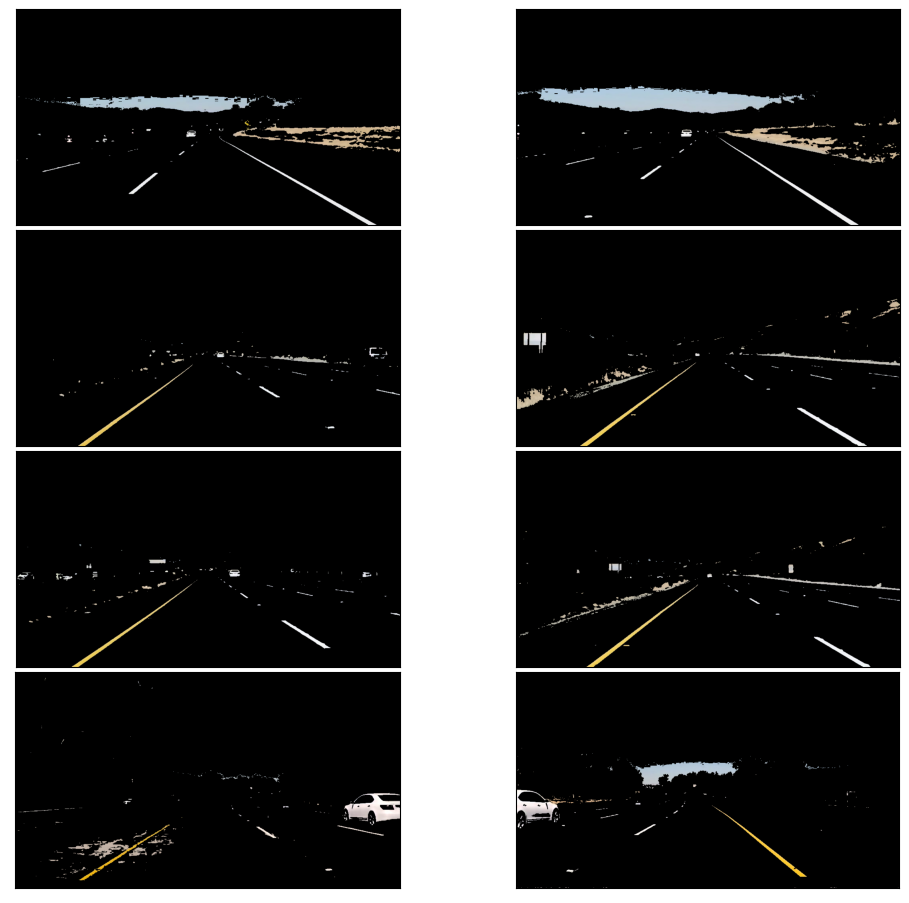

In [65]:
list_images(list(map(RGB_color_selection, test_images)))

In [66]:
# convering rgb to hsv
def convert_hsv(image):

    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# list_images(list(map(convert_hsv, test_images)))

In [67]:
# color selection using hsv
def HSV_color_selection(image):
    converted_image = convert_hsv(image)
    
    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

In [68]:
# list_images(list(map(HSV_color_selection, test_images)))

In [69]:
def convert_hsl(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# list_images(list(map(convert_hsl, test_images)))

In [70]:
def HSL_color_selection(image):
    converted_image = convert_hsl(image)
    
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

In [71]:
# list_images(list(map(HSL_color_selection, test_images)))

In [72]:
color_selected_images = list(map(HSL_color_selection, test_images))

In [73]:
# Image to grey scale image
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [74]:
gray_images = list(map(gray_scale, color_selected_images))
# list_images(gray_images)

In [75]:
# Smoothing of image
def gaussian_smoothing(image, kernel_size = 13):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)   

In [76]:
blur_images = list(map(gaussian_smoothing, gray_images))
# list_images(blur_images)

In [77]:
# Using canny edge detection to detect edges of road
def canny_detector(image, low_threshold = 50, high_threshold = 150):
    return cv2.Canny(image, low_threshold, high_threshold)

In [78]:
edge_detected_images = list(map(canny_detector, gray_images))
# list_images(edge_detected_images)

In [79]:
# Masking reagion of interest
def region_selection(image):
    mask = np.zeros_like(image)   
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    rows, cols = image.shape[:2]
    # bottom_left  = [cols * 0.1, rows * 0.95]
    # top_left     = [cols * 0.4, rows * 0.6]
    # bottom_right = [cols * 0.9, rows * 0.95]
    # top_right    = [cols * 0.6, rows * 0.6]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [80]:
masked_image = list(map(region_selection, edge_detected_images))
# list_images(masked_image)

In [81]:
# import imutils
# masked_image[6] = imutils.rotate(masked_image[6], angle=15)
# test_images[6] = imutils.rotate(test_images[6], angle=15)

In [82]:
# Mapping lines using haugh transform
def hough_transform(image):
    rho = 1
    theta = np.pi/180
    threshold = 30
    minLineLength = 50
    maxLineGap = 300
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [83]:
hough_lines = list(map(hough_transform, masked_image))

In [84]:
# img = masked_image[7]

In [85]:
# list_images([img])

In [86]:
# Drawing lines on the image
def draw_lines(image, lines, color = [255, 0, 0], thickness = 2):
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

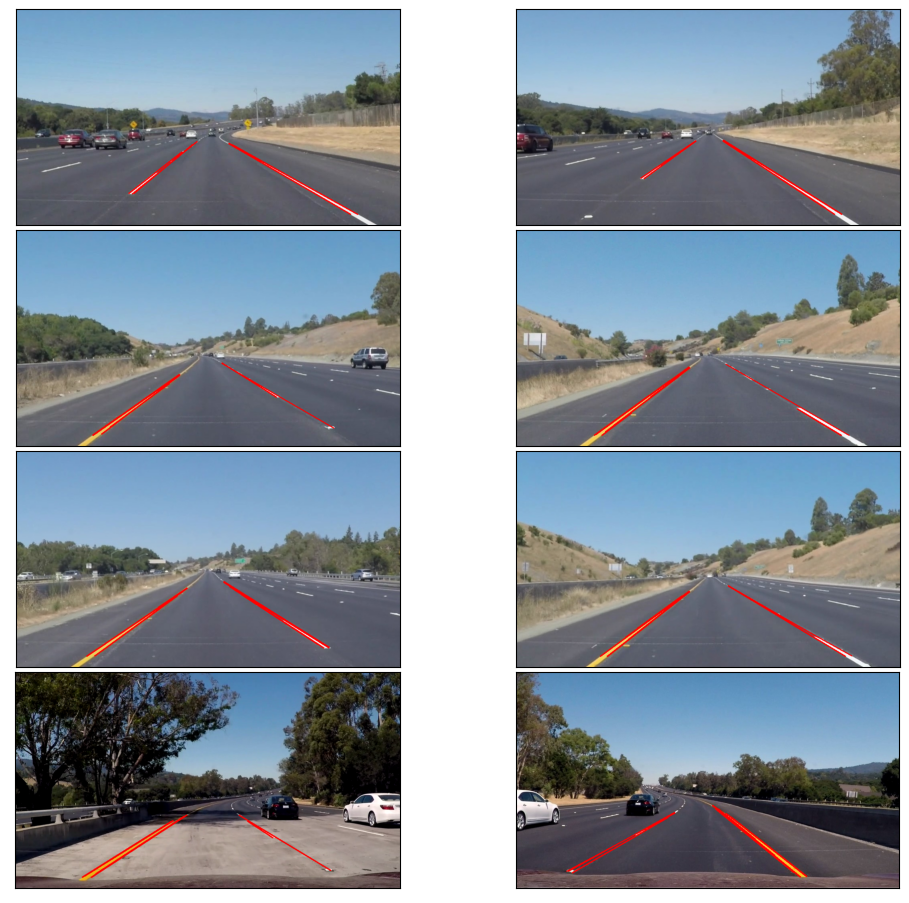

In [87]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [88]:
def map_coordinates(frame, parameters):
    
    height, width, _ = frame.shape
    slope, intercept = parameters
    
    if slope == 0:
        slope = 0.1
    
    y1 = height
    y2 = int(height*0.6)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return [[x1, y1, x2, y2]]

In [89]:
# Otimizing the line by joining and streaching them
def optimize_lines(frame, lines):
    height, width, _ = frame.shape
    
    if lines is not None:
        lane_lines = []
        left_fit = []
        right_fit = []        
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)

            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            
            if slope < 0:
                left_fit.append((slope, intercept))
            else:   
                right_fit.append((slope, intercept))

        if len(left_fit) > 0:
            left_fit_average = np.average(left_fit, axis=0)
            lane_lines.append(map_coordinates(frame, left_fit_average))
            
        if len(right_fit) > 0:
            right_fit_average = np.average(right_fit, axis=0)
            lane_lines.append(map_coordinates(frame, right_fit_average))
        
    return lane_lines

In [90]:
opt_lines = []
for image, lines in zip(test_images, hough_lines):
    opt_lines.append(optimize_lines(image, lines))

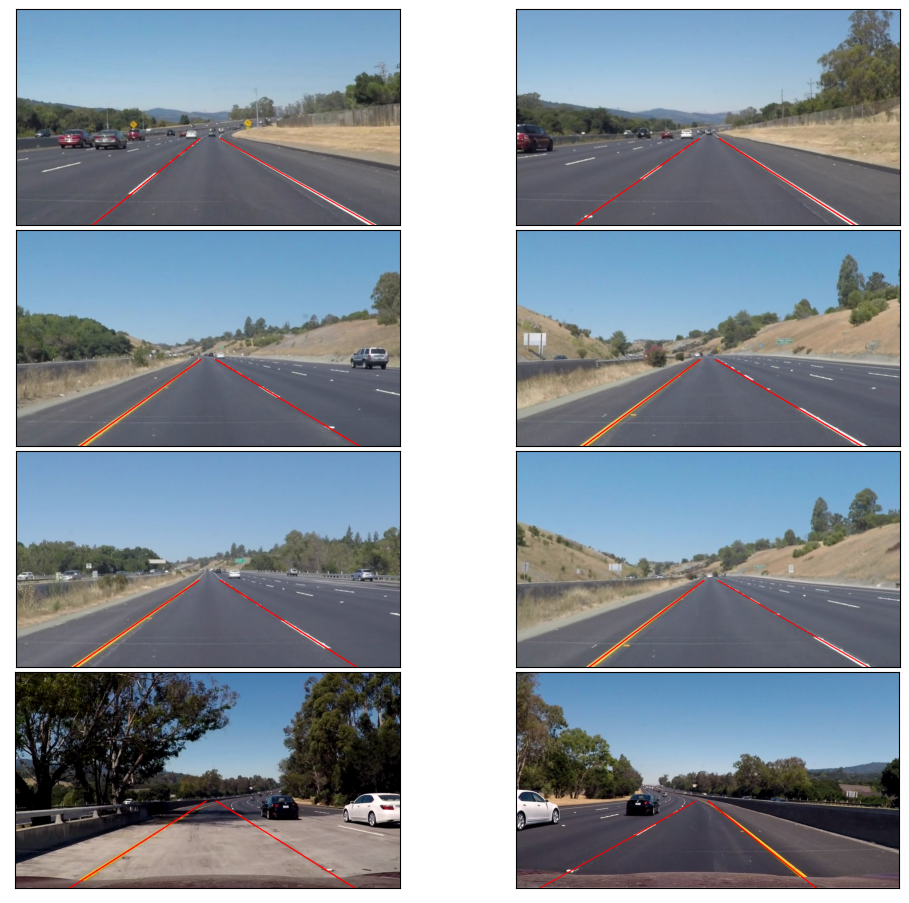

In [91]:
line_images = []
for image, lines in zip(test_images, opt_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [92]:
# Center of lines on the image
def get_floating_center(frame, lane_lines):
    
    height, width, _ = frame.shape
    
    if len(lane_lines) == 2:
        left_x1, _, left_x2, _ = lane_lines[0][0]
        right_x1, _, right_x2, _ = lane_lines[1][0]
        
        low_mid = (right_x1 + left_x1) / 2
        up_mid = (right_x2 + left_x2) / 2

    else:
        up_mid = int(width*1.9)
        low_mid = int(width*1.9)
    
    return up_mid, low_mid

In [93]:
# Getting the deviation by comparing the center point of actual line and the detected lines in the projection (based on the distribution of white lines)
def add_text(frame, image_center, left_x_base, right_x_base):

    lane_center = left_x_base + (right_x_base - left_x_base) / 2
    
    deviation = image_center - lane_center

    if deviation >= 108:
        text = "Straight"
    elif deviation <= 108 and deviation >= 94:
        text = "Left"
    elif deviation <= 94:
        text = "Right"
    # print(deviation, image_center, lane_center, text)
    
    cv2.putText(frame, "Final: " + text, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    return frame

In [94]:
# Generating the histogram to measure the lane lines
def histogram(frame):
    
    histogram = np.sum(frame, axis=0)   
    midpoint = np.int(histogram.shape[0]/2)    
    
    left_x_base = np.argmax(histogram[:midpoint])
    
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_x_base, right_x_base

In [95]:
# Calculating the region of interest for getting the lines
# def op():
#     height, width = image.shape[:2]
#     source_points = np.float32([[int(width*0.4), int(height*0.6)],
#                       [int(width*0.6), int(height*0.6)],
#                       [int(width*0.1), height*0.95],
#                       [int(width*0.9), height*0.95]])
#     print(source_points)
# op()

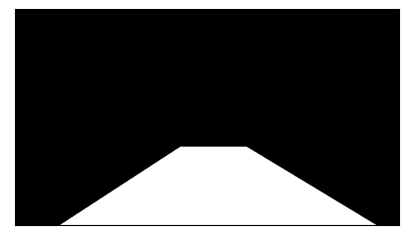

In [96]:
mm = np.zeros_like(test_images[0])
height, width = test_images[0].shape[:2]
sp = np.array([ [412.5, 345],
                        [112.5, height],
                        [900, height],
                        [577.5, 345]], dtype=np.int32)
cv2.fillPoly(mm, np.int32([sp]), (255,) * (test_images[0].shape[2]))
list_images([mm])

In [97]:
# Changing the prespective of the region of interst got get the top view
def warp_perspective(frame):
    height, width = image.shape[:2]

    
    # (1280, 720)
    # self.src = np.float32([(550, 460),     # top-left
    #                            (150, 720),     # bottom-left
    #                            (1200, 720),    # bottom-right
    #                            (770, 460)])    # top-right
    #     self.dst = np.float32([(100, 0),
    #                            (100, 720),
    #                            (1100, 720),
    #                            (1100, 0)])

    # # (960, 540)
    # source_points = np.float32(
    #                   [
    #                     [412.5, 345],
    #                     [112.5, height],
    #                     [900, height],
    #                     [577.5, 345],
    #                 ]
    #               )
    
    source_points = np.float32(
                      [
                        [425, 330],
                        [112.5, height],
                        [900, height],
                        [565, 330],
                    ]
                  )


    # (960, 540)
    # source_points = np.float32(
    #                   [
    #                     [width*0.465, int(height*0.6)],
    #                     [int(width*0.1), height*0.99],
    #                     [int(width*0.9), height*0.99],
    #                     [width*0.535, int(height*0.6)],
    #                 ]
    #               )


    # source_points = np.float32(
    #                   [[450, 318],
    #                   [498, 318],
    #                   [162, 533],
    #                   [850, 533]]
    #                   )
    
    # destination_points = np.float32([[0, 0],
    #                   [width, 0],
    #                   [0, height],
    #                   [width, height]])
    offset = 50
    # offset = 100
    destination_points = np.float32([[offset, 0],
                      [offset, height],
                      [width-2*offset, height],
                      [width-2*offset, 0]])
    # source_points = np.float32(
    #     [[273,680],
    #      [1046,680],
    #      [585,455],
    #      [700,455]])

    # destination_points = np.float32(
    #     [[300,720],
    #      [980,720],
    #      [300,0],
    #      [980,0]])
    # source_points = np.float32([(580, 460), (205, 720), (1110, 720), (703, 460)])
    # destination_points = np.float32([(320, 0), (320, 720), (960, 720), (960, 0)])
    
    matrix = cv2.getPerspectiveTransform(source_points, destination_points) 
    
    skyview = cv2.warpPerspective(frame, matrix, (width, height))    

    return skyview

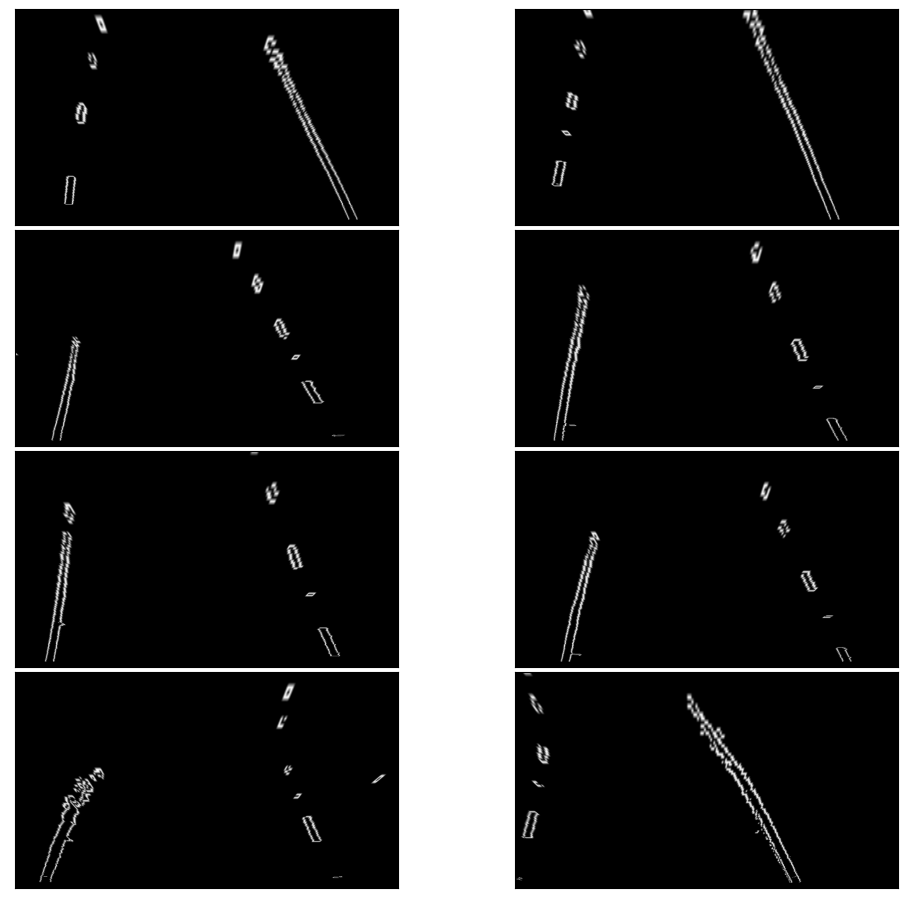

In [98]:
tt = []
for mi in masked_image:
  im = warp_perspective(mi)
  tt.append(im)
list_images(tt)

In [99]:
# len(test_images), len(opt_lines), len(line_images), len(masked_image)

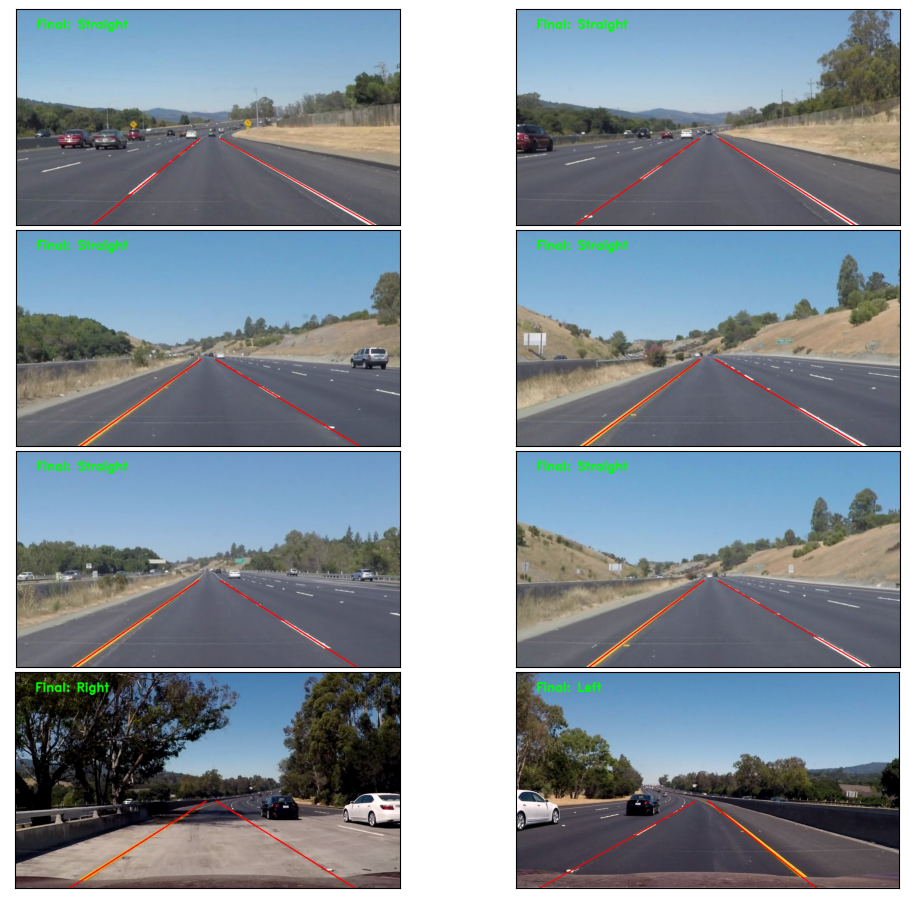

'\nstraight   \nstraight\nstraight \nstraight\nstraight \nstraight\nright \nleft\n'

In [100]:
temp = []
it = []
for image, lines, op_frame, mi in zip(test_images, opt_lines, line_images, masked_image):
  im = warp_perspective(mi)
  it.append(im)
  left_x_base, right_x_base = histogram(im)
  _, low_center = get_floating_center(image, lines)
  final_frame = add_text(op_frame, low_center, left_x_base, right_x_base)
  temp.append(final_frame)
# list_images(it)
list_images(temp)
"""
straight   
straight
straight 
straight
straight 
straight
right 
left
"""

In [174]:
def frame_processing(image):
    # global frame_no
    # print(frame_no)
    color_select = HSL_color_selection(image)
    gray         = gray_scale(color_select)
    smooth       = gaussian_smoothing(gray)
    edges        = canny_detector(smooth)
    masked_image       = region_selection(edges)
    # list_images([masked_image])
    hough_line = hough_transform(masked_image)
    opt_line = optimize_lines(image, hough_line)
    line_image = draw_lines(image, opt_line)
    im = warp_perspective(masked_image)
    # list_images([im])
    left_x_base, right_x_base = histogram(im)
    _, low_center = get_floating_center(image, opt_line)
    final_frame = add_text(line_image, low_center, left_x_base, right_x_base)

    im = cv2.resize(im, (final_frame.shape[1], final_frame.shape[0]))

    return np.concatenate((cv2.merge([im, im, im]), final_frame), axis=1)

In [175]:

def process_video(test_video, output_video):
    input_video =  VideoFileClip(os.path.join('test_videos', test_video), audio=False)
    processed = input_video.fl_image(frame_processing)
    processed.write_videofile(os.path.join('op_videos', output_video), audio=False)

In [176]:
%time process_video('solidYellowLeft.mp4', 'op3.mp4')

Moviepy - Building video op_videos\op3.mp4.
Moviepy - Writing video op_videos\op3.mp4



Moviepy - Done !
Moviepy - video ready op_videos\op3.mp4
CPU times: total: 52.4 s
Wall time: 23.8 s


In [ ]:
# HTML("""<video width="960" height="540" controls><source src="op_videos/op3.mp4"></video>""")